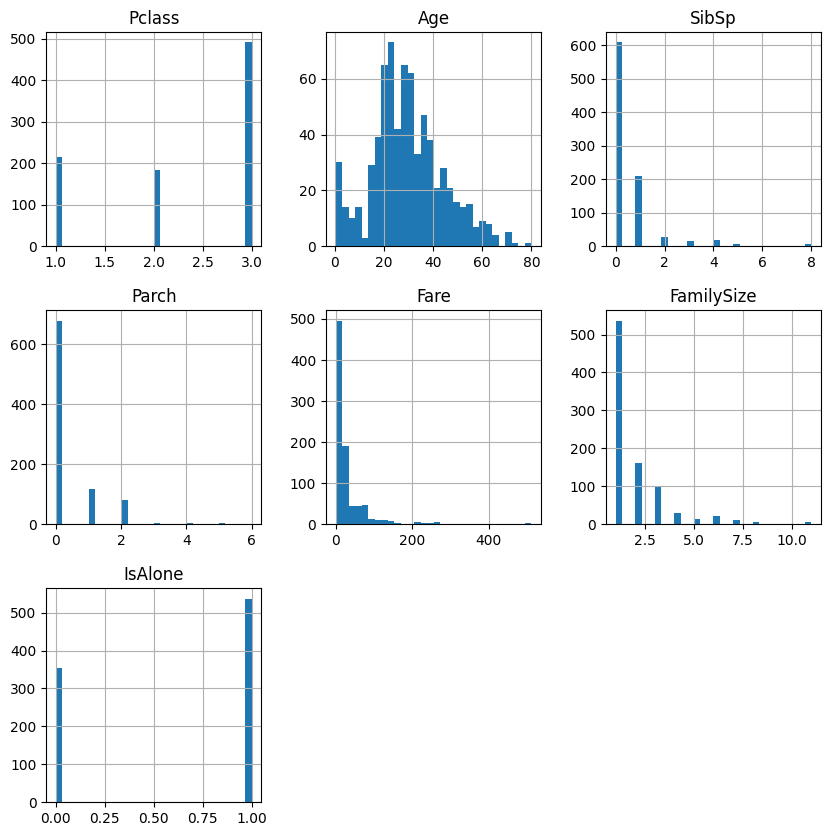

Data frame splitting completed.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
def read_csv (path):
    train_data = pd.read_csv(path)
    return train_data

train_data =  read_csv('train.csv')
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data['IsAlone'] = np.where(train_data['FamilySize'] == 1, 1, 0)
train_data['Name_extract'] = train_data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

train_data_num = train_data.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked','Survived','PassengerId','Name_extract'])
train_data_text = train_data.drop(columns=['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Name','FamilySize','IsAlone'])
train_data_target = train_data['Survived']

corr_matrix = train_data_num.corr()
training_data = train_data.drop(["Survived"], axis=1)
train_data_num.hist(figsize=(10, 10), bins=30)
plt.show()
print("Data frame splitting completed.")

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_attributes = list(train_data_num)
text_attributes = list(train_data_text)
text_attributes_1 = [x for x in text_attributes if x not in ['Ticket', 'Cabin']]
text_attributes_2 = [x for x in text_attributes if x in ['Ticket', 'Cabin']]

num_pipeline = Pipeline([  
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
    ('scaler', StandardScaler())
])

text_pipeline_1 = Pipeline([
    ('impute_text', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

text_pipeline_2 = Pipeline([
    ('impute_text', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot_encoder',OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

pre_processor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_attributes),
        ('text', text_pipeline_1, text_attributes_1),
        ('text2', text_pipeline_2, text_attributes_2),   
    ],
)

print("Data preprocessing completed.")

Data preprocessing completed.


In [4]:
from sklearn.utils.class_weight import compute_class_weight 

class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Survived"]),y=train_data["Survived"])
class_weight_dict = dict(enumerate(class_weight))
print("Class weights computed")
print(class_weight_dict)


Class weights computed
{0: 0.8114754098360656, 1: 1.3026315789473684}


In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

sgd_clf = SGDClassifier(random_state=42,loss="hinge",penalty="l2",max_iter=1000, tol=1e-3,
                        alpha=0.00001, learning_rate="optimal", eta0=0.0, power_t=0.5,
                        early_stopping=True,)

svm_clf = SVC(kernel="rbf", C=1.0, gamma='scale', probability=True,random_state=42)

rf_clf = RandomForestClassifier(n_estimators=221, max_depth=None, criterion='log_loss',
                                min_samples_split=8, min_samples_leaf=1,
                                max_features='sqrt', bootstrap=True,ccp_alpha=0.0,
                                class_weight=class_weight_dict, random_state=42,warm_start=True)

dt_clf = DecisionTreeClassifier(random_state=42,max_depth=None, min_samples_split=2,criterion='log_loss',
                                splitter='best', min_samples_leaf=1,class_weight=class_weight_dict)

model_pipeline = Pipeline([('preprocessor', pre_processor),('classifier', rf_clf)])

scoring = {'accuracy': 'accuracy','precision': make_scorer(precision_score, zero_division=0),
           'recall': make_scorer(recall_score, zero_division=0),'f1': make_scorer(f1_score, zero_division=0)}

scores = cross_validate(model_pipeline,training_data,train_data_target,scoring=scoring,
                         cv=25,error_score='raise',n_jobs=-1,verbose=1)
scores_list = pd.DataFrame(scores)
print(scores_list.mean(axis=0))  
print("Cross-validation completed.")     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fit_time          0.578854
score_time        0.023430
test_accuracy     0.831714
test_precision    0.791394
test_recall       0.771209
test_f1           0.776253
dtype: float64
Cross-validation completed.


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.4s finished


In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

xgb_clf = XGBClassifier(n_estimators=409, max_depth=8, learning_rate=0.133295,
                        subsample=0.6125253, colsample_bytree=0.782236, random_state=42,
                        use_label_encoder=False, eval_metric='aucpr', 
                        scale_pos_weight=class_weight_dict[1],)
xgb_pipeline = Pipeline([('preprocessor', pre_processor),('classifier', xgb_clf)])
xgb_scores = cross_validate(xgb_pipeline, training_data, train_data_target, scoring=scoring,
                            cv=25, error_score='raise', n_jobs=-1, verbose=1)
xgb_scores_list = pd.DataFrame(xgb_scores)
print(xgb_scores_list.mean(axis=0))

param_dict = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': randint(3, 15),
    'classifier__learning_rate': uniform(0.01, 0.29),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 1.0),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__gamma': randint(0, 5),
    'classifier__use_label_encoder': [False],
    'classifier__eval_metric': ['logloss','error','auc', 'aucpr','merror','mlogloss'],
    'classifier__scale_pos_weight': [class_weight_dict[1]]
}

rd_search = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=param_dict, n_iter=50,
                               scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)
rd_search.fit(training_data, train_data_target)
print(rd_search.best_params_, rd_search.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:06] WARNING: /Users/

fit_time          0.736632
score_time        0.012293
test_accuracy     0.821619
test_precision    0.779311
test_recall       0.751429
test_f1           0.760626
dtype: float64
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:08] WARNING: /Users/runner/work/xgboost/xgboost/

{'classifier__colsample_bytree': 0.7822360877880623, 'classifier__eval_metric': 'aucpr', 'classifier__gamma': 1, 'classifier__learning_rate': 0.13329520360246094, 'classifier__max_depth': 8, 'classifier__max_features': 'log2', 'classifier__min_child_weight': 4, 'classifier__n_estimators': 409, 'classifier__scale_pos_weight': 1.3026315789473684, 'classifier__subsample': 0.6125253169822235, 'classifier__use_label_encoder': False} 0.8406377502981608


In [7]:
from scipy.stats import randint

param_dict = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__ccp_alpha': [0.0, 0.01, 0.1],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [class_weight_dict, None],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__warm_start': [True, False],
    'classifier__n_estimators': randint(100, 300),
}
# Perform RandomizedSearchCV with SVC-specific parameters
random_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dict, n_iter=10,
                                   scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(training_data, train_data_target)
print(random_search.best_params_, random_search.best_score_)
print("random_search completed.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': {0: 0.8114754098360656, 1: 1.3026315789473684}, 'classifier__criterion': 'log_loss', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 221, 'classifier__warm_start': True} 0.8328102441780176
random_search completed.


[[0.84307601 0.15692399]
 [0.03377923 0.96622077]
 [0.50249819 0.49750181]
 ...
 [0.45067544 0.54932456]
 [0.52956726 0.47043274]
 [0.93096803 0.06903197]]


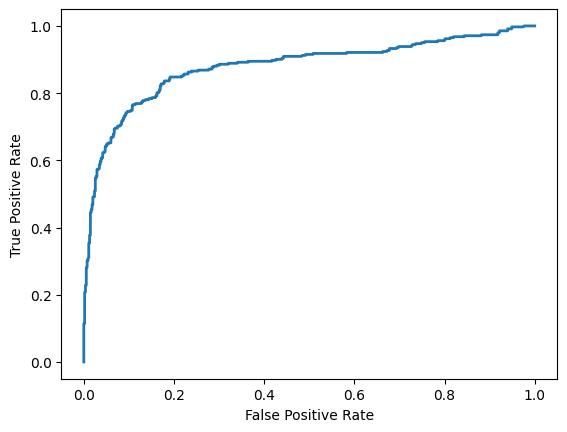

Model training and evaluation completed.


In [8]:
from sklearn.model_selection import cross_val_predict

prd_scores = cross_val_predict(model_pipeline, train_data ,train_data_target, cv=20,method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(train_data_target, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")

In [9]:
model_pipeline.fit(training_data, train_data_target)
xgb_pipeline.fit(training_data, train_data_target)

test_data = read_csv('test.csv')
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['IsAlone'] = np.where(test_data['FamilySize'] == 1, 1, 0)
test_data['Name_extract'] = test_data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

predict_surviving = xgb_pipeline.predict(test_data)
sub_data = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predict_surviving})
sub_data.to_csv('submission.csv', index=False)
print("Submission file created.")
print(sub_data)

/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:16:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Submission file created.
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         1
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
